In [1]:
import cv2
import os
import operator
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from sklearn.metrics import f1_score 
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D

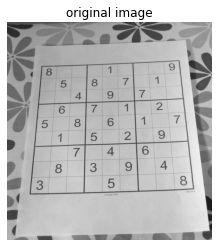

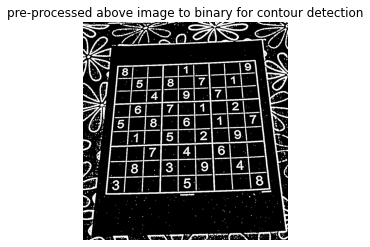

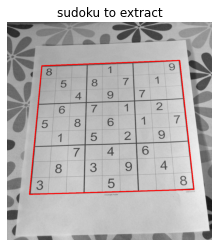

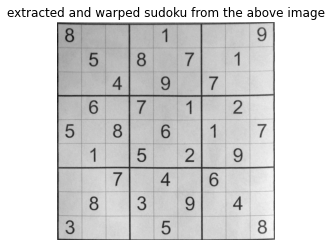

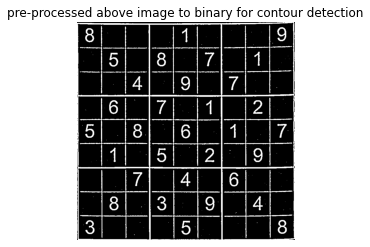

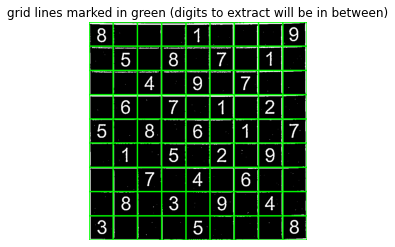

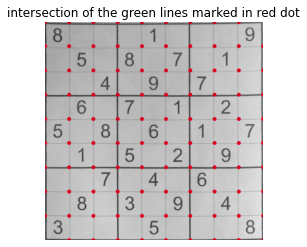

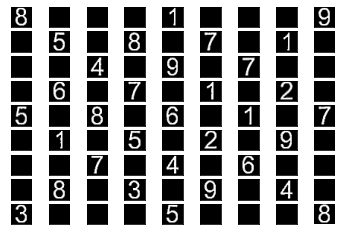

In [2]:
import imageio
# functions for image processing
def plot_many_images(images, titles='', rows=9, columns=9):
    """Plots each image in a given list as a grid structure. using Matplotlib."""
    plt.title('Extracted elements from sudoku')
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.axis('off')
    plt.show()


def show_image(img, title='', flag=0):
    if flag!=0:
        return True
    """Shows an image until any key is pressed"""
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def pre_process_image(img, skip_dilate=False, flag=0):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)

    show_image(proc, 'pre-processed above image to binary for contour detection', flag)
    return proc


def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect, flag=0):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    show_image(warp, 'extracted and warped sudoku from the above image', flag)
    #print(type(warp))
    imageio.imwrite('images\warped_image.jpeg', warp)
    
    return warp


def infer_grid(img):
    """Infers 81 cell grid from a square image."""
    squares = []
    side = img.shape[:1]
    side = side[0] / 9

    # Note that we swap j and i here so the rectangles are stored in the list reading left-right instead of top-down.
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares


def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
    connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
    """
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]

    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]

    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point


def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""

    digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)


def get_digits(img, squares, size, flag=0):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True, flag=flag)
    ii = img.copy()
    ii = cv2.cvtColor(ii, cv2.COLOR_GRAY2BGR)
    for square in squares:
        digits.append(extract_digit(img, square, size))
        a,b = (int(square[0][0]),int(square[0][1])), (int(square[1][0]),int(square[1][1]))
        cv2.rectangle(ii, a, b, (0,255,0), 3)
    show_image(ii, 'grid lines marked in green (digits to extract will be in between)', flag)
    return digits


def parse_grid(path, flag=0):
    original = cv2.imread(path, 0)
    
    rgb_img = cv2.cvtColor(original.copy(), cv2.COLOR_BGR2RGB)
    show_image(rgb_img, 'original image', flag)

    processed = pre_process_image(original, flag=flag)
    corners = find_corners_of_largest_polygon(processed)
    cv2.line(rgb_img, tuple(corners[0]), tuple(corners[1]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[1]), tuple(corners[2]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[2]), tuple(corners[3]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[3]), tuple(corners[0]), (255,0,0), 3)
    show_image(rgb_img, 'sudoku to extract', flag)
    
    cropped = crop_and_warp(original, corners, flag)
    squares = infer_grid(cropped)
    digits = get_digits(cropped, squares, 28, flag=flag)
    warp_img = cv2.cvtColor(cropped.copy(), cv2.COLOR_BGR2RGB)
    for a,b in squares:
        x,y = int(a[0]), int(a[1])
        w,z = int(b[0]), int(b[1])
        cv2.circle(warp_img, (x,y), 7, (220,0,30), -1)
        cv2.circle(warp_img, (w,z), 7, (220,0,30), -1)
    show_image(warp_img, 'intersection of the green lines marked in red dot', flag)
    return digits

path = 'images\sudoku.jpg'
digits = parse_grid(path, flag=0)
plot_many_images(digits)

In [3]:
def to_bin(data):
    """Convert `data` to binary format as string"""
    if isinstance(data, str):
        return ''.join([ format(ord(i), "08b") for i in data ])
    elif isinstance(data, bytes) or isinstance(data, np.ndarray):
        return [ format(i, "08b") for i in data ]
    elif isinstance(data, int) or isinstance(data, np.uint8):
        return format(data, "08b")
    else:
        raise TypeError("Type not supported.")

In [4]:
def encode(image_name, secret_data):
    # read the image
    image = cv2.imread(image_name)
    # maximum bytes to encode
    n_bytes = image.shape[0] * image.shape[1] * 3 // 8
    print("[*] Maximum bytes to encode:", n_bytes)
    if len(secret_data) > n_bytes:
        raise ValueError("[!] Insufficient bytes, need bigger image or less data.")
    print("[*] Encoding data...")
    # add stopping criteria
    secret_data += "====="
    data_index = 0
    # convert data to binary
    binary_secret_data = to_bin(secret_data)
    # size of data to hide
    data_len = len(binary_secret_data)
    for row in image:
        for pixel in row:
            # convert RGB values to binary format
            r, g, b = to_bin(pixel)
            # modify the least significant bit only if there is still data to store
            if data_index < data_len:
                # least significant red pixel bit
                pixel[0] = int(r[:-1] + binary_secret_data[data_index], 2)
                data_index += 1
            if data_index < data_len:
                # least significant green pixel bit
                pixel[1] = int(g[:-1] + binary_secret_data[data_index], 2)
                data_index += 1
            if data_index < data_len:
                # least significant blue pixel bit
                pixel[2] = int(b[:-1] + binary_secret_data[data_index], 2)
                data_index += 1
            # if data is encoded, just break out of the loop
            if data_index >= data_len:
                break
    return image

In [5]:
def decode(image_name):
    print("[+] Decoding...")
    # read the image
    image = cv2.imread(image_name)
    binary_data = ""
    for row in image:
        for pixel in row:
            r, g, b = to_bin(pixel)
            binary_data += r[-1]
            binary_data += g[-1]
            binary_data += b[-1]
    # split by 8-bits
    all_bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
    # convert from bits to characters
    decoded_data = ""
    for byte in all_bytes:
        decoded_data += chr(int(byte, 2))
        if decoded_data[-5:] == "=====":
            break
    return decoded_data[:-5]

In [6]:
def steganography():
  if __name__ == "__main__":
    input_image = 'images\warped_image.jpeg'
    output_image = "images\encoded_image.PNG"
    secret_data = input("Enter the secret message")
    # encode the data into the image
    encoded_image = encode(image_name=input_image, secret_data=secret_data)
    # save the output image (encoded image)
    cv2.imwrite(output_image, encoded_image)
    # decode the secret data from the image
    print('What is the code??')
    while True:
      n=int(input())
      if n==10:
        decoded_data = decode(output_image)
        print("[+] Decoded data:", decoded_data)
        im = imageio.imread(input_image)
        show_image(encoded_image, 'encoded image', 0)
        break
      else:
        print('Try Again!')

In [7]:
board = [
    [0,0,5,0,9,0,0,0,0],
    [4,0,9,0,0,0,0,0,0],
    [0,2,8,0,7,0,3,0,5],
    [5,0,4,0,0,1,0,0,0],
    [0,0,0,8,0,9,0,0,0],
    [0,0,0,5,0,0,2,0,4],
    [7,0,3,0,8,0,4,2,0],
    [0,0,0,0,0,0,6,0,3],
    [0,0,0,0,2,0,5,0,0]
]

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

In [8]:
# creating the model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (16,16), input_shape=(28, 28, 1), activation='relu'))
    model.add(Conv2D(8, (8,8), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(units=11, activation='softmax'))
    return model

In [9]:
# Gathering the data for training the model
def get_data():
    data = pd.read_csv('image_data.csv')
    X = []
    Y = data['y']
    del data['y']
    for i in range(data.shape[0]):
        flat_pixels = data.iloc[i].values[1:]
        image = np.reshape(flat_pixels, (28,28))
        X.append(image)

    X = np.array(X)
    Y = np.array(Y)

    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.3, random_state=22)

    #reshaping data
    X_train = X_train.reshape(-1,28,28,1)
    X_test  = X_test.reshape(-1,28,28,1)

    return X_train, X_test, Y_train, Y_test

In [10]:

# Getting predictions from the trained model
def predict_digits(model, digits):
    dic = {}
    char = "1234567890"
    for i,c in enumerate(char):
        dic[i+1] = c
    sudoku = []
    row = []
    for i,dig in enumerate(digits):
        img = dig.reshape(-1,28,28,1)
        pred = model.predict_classes(img)[0]
        character = dic[pred]
        row.append(int(character))
        if((i+1)%9==0):
            sudoku.append(row)
            row = []
    return np.array(sudoku)

In [11]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

def train_model(model):
    X_train, X_test, Y_train, Y_test = get_data()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1score])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=16, verbose=2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model

In [12]:
def getPixelimg(path):
    # Importing Image from PIL package
    from PIL import Image
 
    # creating a image object
    im = Image.open(path)
    px = im.load()
    print (px[9, 9])
    px[9, 9] = (0, 0, 0)
    print (px[9, 9])
    coordinate = x, y = 150, 59
 
    # using getpixel method
    print (im.getpixel(coordinate))

In [13]:
from keras.utils.vis_utils import plot_model
# main function takes the sudoku image file path as input
def main(path):
    digits = parse_grid(path, flag=1)
    model = create_model()
    """if 'model.h5' in os.listdir('G:\My Drive\VIT SEM\FALL20-21\CSE2003 DSA\research paper\project\model.h5'):
        model.load_weights('model.h5')
    else:"""
    model = train_model(model)
    #plot_model(model, to_file='test.jpg', show_shapes=True, show_layer_names=True)
        
    sudoku = predict_digits(model, digits)
    digits = parse_grid(path, flag=0)
    plot_many_images(digits)
    #getPixelimg("images\warped_image.jpeg")
    steganography()
    #getPixelimg("images\encoded_image.jpeg")
    print("Input Sudoku:\n")
    print_board(sudoku)
    solve(sudoku)
    print("\n____________________________________\nSolved Sudoku:\n")
    print_board(sudoku)

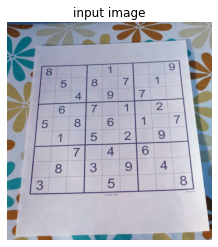

In [14]:
img = cv2.imread(path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('input image')
plt.show()

In [15]:
#main(path)

In [16]:
from IPython.display import display, Javascript
from js2py import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Saved to images\sudoku.jpg
Epoch 1/40
14/14 - 2s - loss: 2.3103 - accuracy: 0.1667 - custom_f1score: 0.1875 - val_loss: 2.0784 - val_accuracy: 0.2111 - val_custom_f1score: 0.2104
Epoch 2/40
14/14 - 0s - loss: 2.0046 - accuracy: 0.2524 - custom_f1score: 0.2679 - val_loss: 1.7362 - val_accuracy: 0.3556 - val_custom_f1score: 0.3521
Epoch 3/40
14/14 - 0s - loss: 1.6376 - accuracy: 0.3762 - custom_f1score: 0.4152 - val_loss: 1.3026 - val_accuracy: 0.4444 - val_custom_f1score: 0.4354
Epoch 4/40
14/14 - 0s - loss: 1.3508 - accuracy: 0.5476 - custom_f1score: 0.5446 - val_loss: 1.0351 - val_accuracy: 0.7889 - val_custom_f1score: 0.7896
Epoch 5/40
14/14 - 0s - loss: 1.1482 - accuracy: 0.6476 - custom_f1score: 0.6696 - val_loss: 0.6234 - val_accuracy: 0.9444 - val_custom_f1score: 0.9417
Epoch 6/40
14/14 - 0s - loss: 0.7939 - accuracy: 0.8048 - custom_f1score: 0.7857 - val_loss: 0.5337 - val_accuracy: 0.9556 - val_custom_f1score: 0.9583
Epoch 7/40
14/14 - 0s - loss: 0.7197 - accuracy: 0.8190 - cus

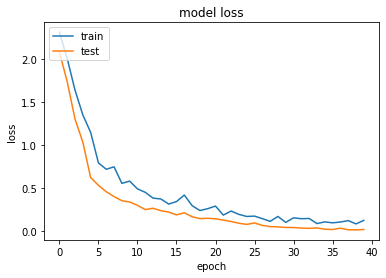

C:\Users\mukho\anaconda3\envs\dsa-rp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


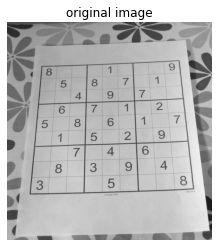

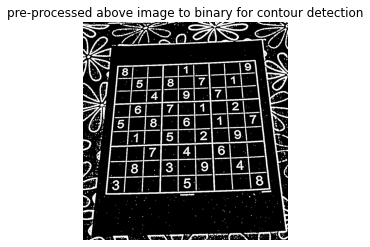

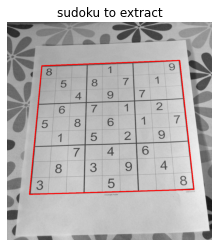

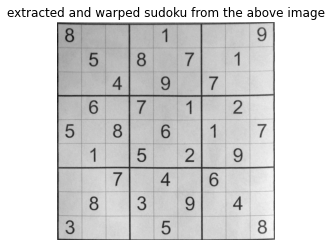

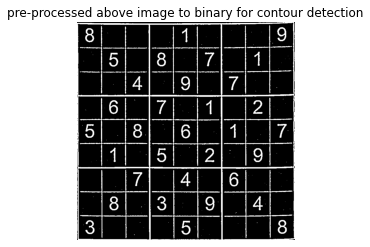

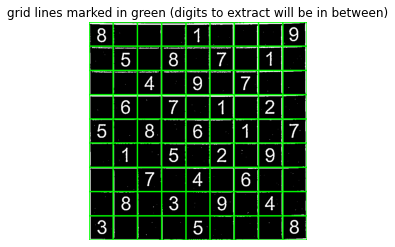

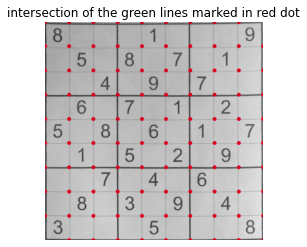

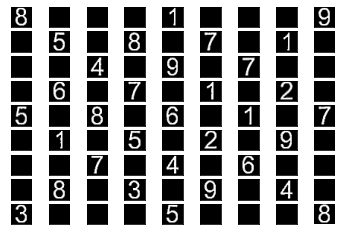

KeyboardInterrupt: Interrupted by user

In [17]:
from IPython.display import Image
try:
  #filename = take_photo()
  filename = "images\sudoku.jpg"
  
  print('Saved to {}'.format(filename))
  
  #Show the image which was just taken.
  #display(Image(filename))
  
  

  img = cv2.imread(filename)
  #print(type(img))
  #print(img.shape)
  #img_flip_lr = cv2.flip(img, 1)
  #cv2.imwrite('photo_flip.jpg', img_flip_lr)
  #main('photo.jpg')
  main(filename)
  input_image = cv2.imread('images\warped_image.jpeg')
  output_image = cv2.imread("images\encoded_image.PNG")

  #histr_input = cv2.calcHist([input_image],[0],None,[256],[0,256]) 
  #plt.plot(histr_input) 
  #plt.show() 
  #histr_output = cv2.calcHist([output_image],[0],None,[256],[0,256]) 
  #plt.plot(histr_output) 
  #plt.show() 
 
  #plt.hist(output_image.ravel(),256,[0,256])
  #plt.show()


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

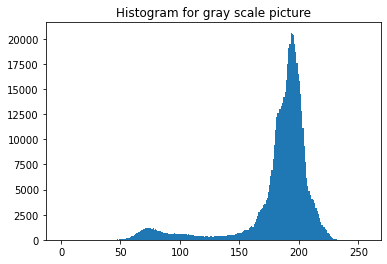

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

gray_img = cv2.imread('images\warped_image.jpeg', cv2.IMREAD_GRAYSCALE)
#cv2.imshow('GoldenGate',gray_img)
hist = cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.hist(gray_img.ravel(),256,[0,256])
plt.title('Histogram for gray scale picture')
plt.show()
